# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils import resample 
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
from tqdm import tqdm_notebook

# Data Processing

In [4]:
df = pd.read_csv('Data/pokemon-data.csv', delimiter=';')
mdf = pd.read_csv('Data/move-data.csv')

**Most preprocessing was done based on work from Nichalas Veduvali**

### Looking at Data

In [5]:
df.head(n=1)

,Name,Types,Abilities,Tier,HP,Attack,Defense,Special Attack,Special Defense,Speed,Next Evolution(s),Moves
0,Abomasnow,"['Grass', 'Ice']","['Snow Warning', 'Soundproof']",PU,90,92,75,92,85,60,[],"['Ice Punch', 'Powder Snow', 'Leer', 'Razor Le..."


In [6]:
df.shape

(918, 12)

In [7]:
mdf.head(n=1)

,Index,Name,Type,Category,Contest,PP,Power,Accuracy,Generation
0,1,Pound,Normal,Physical,Tough,35,40,100,1


In [8]:
mdf.shape

(728, 9)

### Missing Data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
Name                 918 non-null object
Types                918 non-null object
Abilities            918 non-null object
Tier                 820 non-null object
HP                   918 non-null int64
Attack               918 non-null int64
Defense              918 non-null int64
Special Attack       918 non-null int64
Special Defense      918 non-null int64
Speed                918 non-null int64
Next Evolution(s)    918 non-null object
Moves                918 non-null object
dtypes: int64(6), object(6)
memory usage: 86.2+ KB


In [10]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 9 columns):
Index         728 non-null int64
Name          728 non-null object
Type          728 non-null object
Category      728 non-null object
Contest       728 non-null object
PP            728 non-null int64
Power         728 non-null object
Accuracy      728 non-null object
Generation    728 non-null int64
dtypes: int64(3), object(6)
memory usage: 51.3+ KB


While it seems like there's no missing data, turns out the string 'None' is used in place of base values. Power and accuracy should also be numeric for modeling. The lists in the pokemon dataframe are also just strings

In [11]:
mdf.columns

Index(['Index', 'Name', 'Type', 'Category', 'Contest', 'PP', 'Power',
       'Accuracy', 'Generation'],
      dtype='object')

In [12]:
df.columns = ['name', 'types', 'abilities', 'tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'next_evos','moves']

#turn the lists into actual lists
df['next_evos'] = df.apply(lambda x: eval(x.next_evos), axis=1)
df['types'] = df.apply(lambda x: eval(x.types), axis=1)
df['abilities'] = df.apply(lambda x: eval(x.abilities), axis=1)
df['moves'] = df.apply(lambda x: eval(x.moves), axis=1)

df.set_index('name', inplace=True)

In [13]:
mdf.columns = ['index', 'name', 'type', 'category', 'contest', 'pp', 'power', 'accuracy', 'generation']
mdf.set_index('index')
mdf['power'].replace('None', 0, inplace=True)
mdf['accuracy'].replace('None', 100, inplace=True)
mdf['power'] = pd.to_numeric(mdf['power'])
mdf['accuracy'] = pd.to_numeric(mdf['accuracy'])

### Munging

#### Move Names

Names of some moves were stored weird

In [14]:
weird_moves = set()

for ind, row in df.iterrows():
    for move in row.moves:
        if "'" in move:
            weird_moves.add(move)
            
print(weird_moves)

{"Will'O'Wisp", "King's Shield", "Topsy'Turvy", "Freeze'Dry", "Baby'Doll Eyes", "Multi'Attack", "U'turn", "Nature's Madness", "Double'Edge", "Land's Wrath", "Soft'Boiled", "Lock'On", "X'Scissor", "Trick'or'Treat", "Wake'Up Slap", "Self'Destruct", "Mud'Slap", "Forest's Curse", "Power'Up Punch"}


In [15]:
weird_moves.remove("King's Shield")
weird_moves.remove("Forest's Curse")
weird_moves.remove("Land's Wrath")
weird_moves.remove("Nature's Madness")

df['moves'] = df.apply(
    lambda x: [move if move not in weird_moves else move.replace("'", "-")
                  for move in x.moves],
    axis = 1
)

removal_check_set = set()
for ind, row in df.iterrows():
    for move in row.moves:
        if "'" in move:
            removal_check_set.add(move)

removal_check_set

{"Forest's Curse", "King's Shield", "Land's Wrath", "Nature's Madness"}

Some moves are repeated in movesets as they can be learned in multiple ways

In [16]:
df['moves'] = df.apply(lambda x: set(x.moves), axis=1)

Remove Struggle Sketch and Z-moves

In [17]:
mdf = mdf[(mdf.pp != 1) | (mdf.name == 'Sketch')]

In [18]:
mdf.loc['Frusuration', 'power'] = 102
mdf.loc['Return', 'power'] = 102

#### Limbo

In [19]:
df[df['tier'] == 'Limbo']

,types,abilities,tier,hp,atk,def,spa,spd,spe,next_evos,moves
name,,,,,,,,,,,
Floette-Eternal,[Fairy],"[Flower Veil, Symbiosis]",Limbo,74,65,67,125,128,92,[],"{Sunny Day, After You, Calm Mind, Moonblast, T..."
Zeraora,[Electric],[Volt Absorb],Limbo,88,112,75,102,80,143,[],"{Fling, Calm Mind, Thunder Wave, Toxic, Close ..."


In [20]:
#Zeraora is now UU
df['tier']['Zeraora'] = 'UU'

#### Missing Moves

Meltan is also a new pokemon but is not in traditional competitive yet

Deviating from Nicholas here: Zeroara has been release to added to Dataframe as well as plasmas fists. Happy hour, celebrate, and hold back were removed in his version, but Z-Happy hour and Z-Celebrate are actually used often in competitive play due to their omniboost ability. Z-hold back has the same use so it may be useful tho I haven't seen it used.

In [21]:
df.loc['Zeraora', 'moves'].add('Plasma Fists')

for pok in ['Victini', 'Rayquaza', 'Rayquaza-Mega']:
    df.loc[pok, 'moves'].add('V-create')

for pok in ['Zygarde', 'Zygarde-10%', 'Zygarde-Complete']:
    df.loc[pok, 'moves'].add('Thousand Arrows')
    df.loc[pok, 'moves'].add('Thousand Waves')
    df.loc[pok, 'moves'].add('Core Enforcer')

#adding all evolutions and forms that can also use the move
for pok in ['Celebi', 'Serperior', 'Emboar', 'Samurott', 'Mareep', 'Beldum', 'Munchlax', 'Snorlax',
           'Metang', 'Metagross', 'Metagross-Mega', 'Flaaffy', 'Ampharos', 'Ampharos-Mega']:
    df.loc[pok, 'moves'].add('Hold Back')

#only event rockruff can learn celebrate which can only evolve into dusk form
for pok in ['Pikachu', 'Raichu', 'Meowth', 'Persian', 'Magikarp', 'Gyarados', 'Gyarados-Mega',
           'Delibird', 'Jirachi', 'Greninja', 'Inkay', 'Malamar', 'Munchlax',
           'Snorlax', 'Rockruff', 'Lycanroc-Dusk']:
    df.loc[pok, 'moves'].add('Celebrate')
    
for pok in ['Pikachu', 'Charizard', 'Vivillon', 'Raichu', 'Charizard-Mega-X', 'Charizard-Mega-Y']:
    df.loc[pok, 'moves'].add('Hold Hands')

for pok in ['Bulbasaur', 'Ivysaur', 'Venusaur', 'Venusaur-Mega', 'Charmander',
           'Charmeleon', 'Charizard-Mega-X', 'Charizard-Mega-Y',
           'Squirtle', 'Wartortle', 'Blastoise', 'Blastoise-Mega', 'Magikarp', 'Gyarados', 'Gyarados-Mega',
           'Eevee', 'Vaporeon', 'Jolteon', 'Flareon', 'Espeon', 'Umbreon', 'Ho-Oh', 'Rayquaza', 'Rayquaza-Mega',
            'Leafeon', 'Glaceon', 'Sylveon', 'Pikachu', 'Raichu', 'Chansey',
            'Victini', 'Comfey', 'Snorlax', 'Aerodactyl', 'Aerodactyl-Mega',
            'Vulpix-Alola', 'Ninetales-Alola', 'Exeggutor-Alola', 'Shaymin', 'Shaymin-Sky',
            'Meloetta', 'Meloetta-Pirouette']:
    df.loc[pok, 'moves'].add('Happy Hour')

#### Evolution Feature

In [22]:
def stage_in_evo(n):
    # returns number of evolutions before it
    #print(df[df['name'] == n]['name'])
    bool_arr = df.apply(lambda x: n in x['next_evos'] and (n+'-') not in x['next_evos'], axis=1) #gets index of previous evolution
    if ('-' in n and n.split('-')[0] in df.index and n != 'Porygon-Z'): #'-Mega' in n or  
        #megas and alternate forms should have same evolutionary stage as their base
        return stage_in_evo(n.split('-')[0])
    elif not any(bool_arr):
        return 1 # if there's nothing before it, it's the first
    else:
        return 1 + stage_in_evo(df.index[bool_arr][0])

def num_evos(n):
    if n not in df.index: #checks to ensure valid pokemon
        return n
    
    next_evos = df.loc[n, 'next_evos']
    if len(next_evos) > 0: #existence of next_evo
        if n in next_evos[0]: # if "next evo" is an alternate form
            return df.loc[n, 'stage'] #accounting for alternate forms
        else:
            return num_evos(next_evos[0])
    elif '-Mega' in n or (n.split('-')[0] in df.index and n != 'Porygon-Z'): 
        #this is checking if there is a pokemon with the same root name (e.g. Shaymin vs Shaymin-Sky)
        return df.loc[n.split('-')[0], 'stage']
    else:
        return df.loc[n, 'stage']

In [23]:
df['stage'] = df.apply(lambda x: stage_in_evo(x.name), axis=1)
df['num_evos'] = df.apply(lambda x: num_evos(x.name), axis=1)
df['evo_progress'] = df['stage']/df['num_evos'] 
del df['stage']
del df['num_evos']

#### Alternate Form Feature

In [24]:
df['mega'] = df.apply(lambda x: 1 if '-Mega' in x.name else 0, axis=1)
df['alt_form'] = df.apply(lambda x: 1 if ('-' in x.name and 
                                                x.mega == 0 and 
                                                '-Alola' not in x.name and 
                                                x.name.split('-')[0] in df.index and
                                                x.name != 'Porygon-Z')
                                            else 0,
                                            axis = 1)

#### Tiers

Consider adding Little Cup

In [25]:
df.loc[df.tier == 'OUBL','tier'] = 'Uber'
df.loc[df.tier == 'UUBL','tier'] = 'OU'
df.loc[df.tier == 'RUBL','tier'] = 'UU'
df.loc[df.tier == 'NUBL','tier'] = 'RU'
df.loc[df.tier == 'PUBL','tier'] = 'NU'
df = df[df['tier'].isin(['Uber', 'OU', 'UU', 'NU', 'RU', 'PU', 'LC'])]

In [26]:
tiers = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'LC']
tier_mapping = {tier:num for num, tier in enumerate(tiers)}
df['tier_num'] = df.apply(lambda x: tier_mapping[x.tier], axis=1)
tier_mapping

{'Uber': 0, 'OU': 1, 'UU': 2, 'RU': 3, 'NU': 4, 'PU': 5, 'LC': 6}

#### More Features

In [27]:
df['num_moves'] = df.apply(lambda x: len(x.moves), axis=1)

In [28]:
df['bst'] = df['hp'] + df['atk'] + df['def'] + df['spa'] + df['spd'] + df['spe']

features to add:
    Cleric, hazards, pivot, weather, banned abilities

# Exploratory Data Analysis

## Stats

In [29]:
df['tier_num'].value_counts(normalize=True)

6    0.323961
5    0.271394
1    0.094132
3    0.088020
4    0.083130
2    0.081907
0    0.057457
Name: tier_num, dtype: float64

Baselne is 32%, but unfortunately there are fewer pokemon in higher tiers.

In [30]:
df.groupby('tier').count()['bst']

tier
LC      265
NU       68
OU       77
PU      222
RU       72
UU       67
Uber     47
Name: bst, dtype: int64

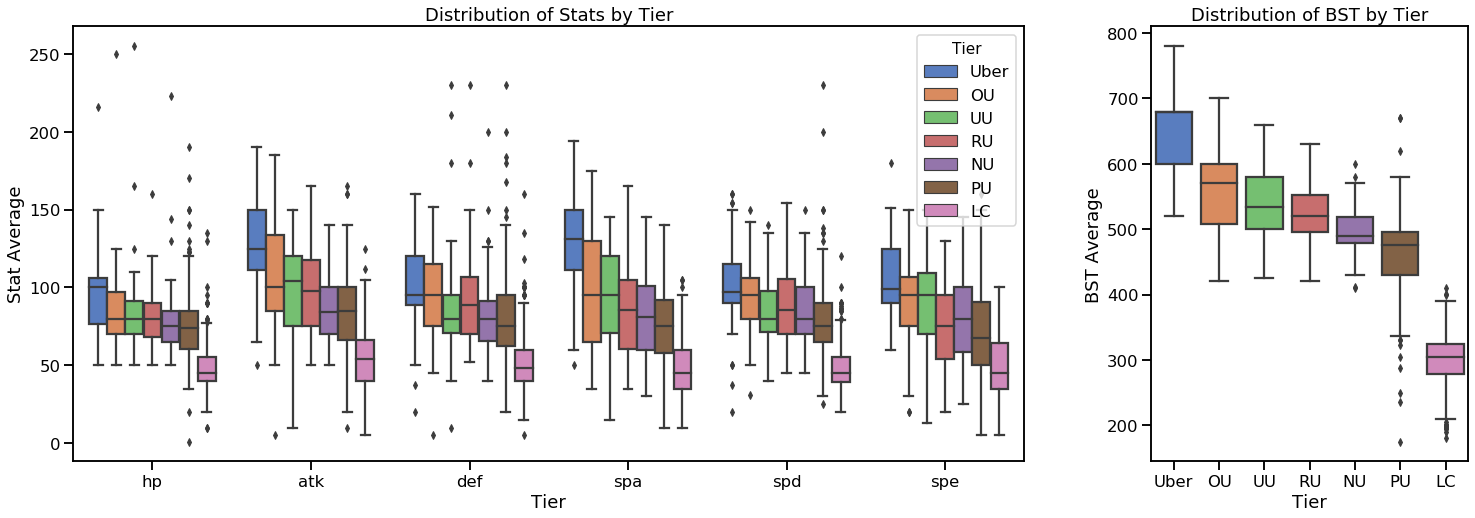

In [31]:
stats_df = df[['tier', 'tier_num', 'hp', 'atk', 'def', 'spa', 'spd', 'spe']]
stats_df = stats_df.reset_index()
stats_df = stats_df.melt(id_vars=['name', 'tier', 'tier_num']).sort_values('tier_num', ascending=True)
stats_df.columns = ('name', 'Tier', 'tier_num', 'Stat', 'Value')
#stats_df.Value = pd.to_numeric(stats_df.Value)

sns.set_context('talk')
fig, ax = plt.subplots(1,2, figsize=(25,8), gridspec_kw = {'width_ratios':[3, 1]})
g = sns.boxplot(data=stats_df, x="Stat", y="Value", order=['hp', 'atk', 'def', 'spa', 'spd', 'spe'],
                hue="Tier", palette="muted", ax=ax[0])
g2 = sns.boxplot(data=df, x='tier', y='bst', order=tiers, palette="muted", ax=ax[1])
#g2=sns.factorplot(x="Tier", y="Average", hue_order=['bst'],hue="Stat", data=temp2,
#                   kind="bar", palette="muted", aspect=1.5,  ax=ax[1])
ax[0].set(xlabel='Tier', ylabel='Stat Average', title='Distribution of Stats by Tier')
ax[1].set(xlabel='Tier', ylabel='BST Average', title='Distribution of BST by Tier');

Strong seperation between LC and Ubers tiers for msot stats but less seperation with middling tiers. Liekly because a pokemon generally excels in only one or two areas and is weaker in others, but base-stat total matters

Lookinhg only at their highest stats

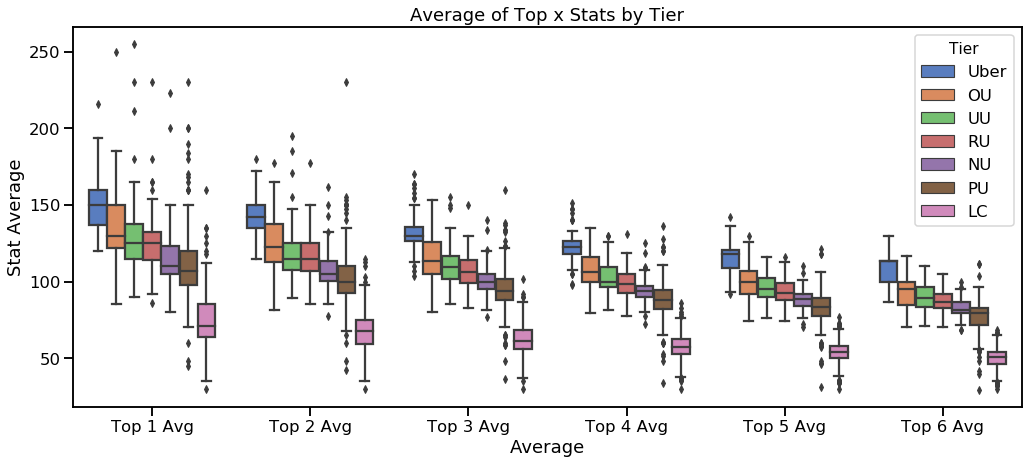

In [32]:
stats_df2 = df.loc[:, ['tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe']].reset_index().set_index(['name','tier'])
aggregates = {('Top {} Avg'.format(v),(lambda x, v=v: np.mean(np.sort(x)[::-1][:v]))) for v in range(1, 7)} 
stats_df2 = stats_df2.stack().groupby(['name','tier']).agg(aggregates).stack().reset_index()
stats_df2.columns = ['Name', 'Tier', 'Average', 'Stat Average']

plt.subplots(figsize=(17,7))
sns.boxplot(data=stats_df2.sort_values('Average'), hue='Tier', y='Stat Average', x='Average', 
            hue_order=tiers, palette='muted').set_title('Average of Top x Stats by Tier');

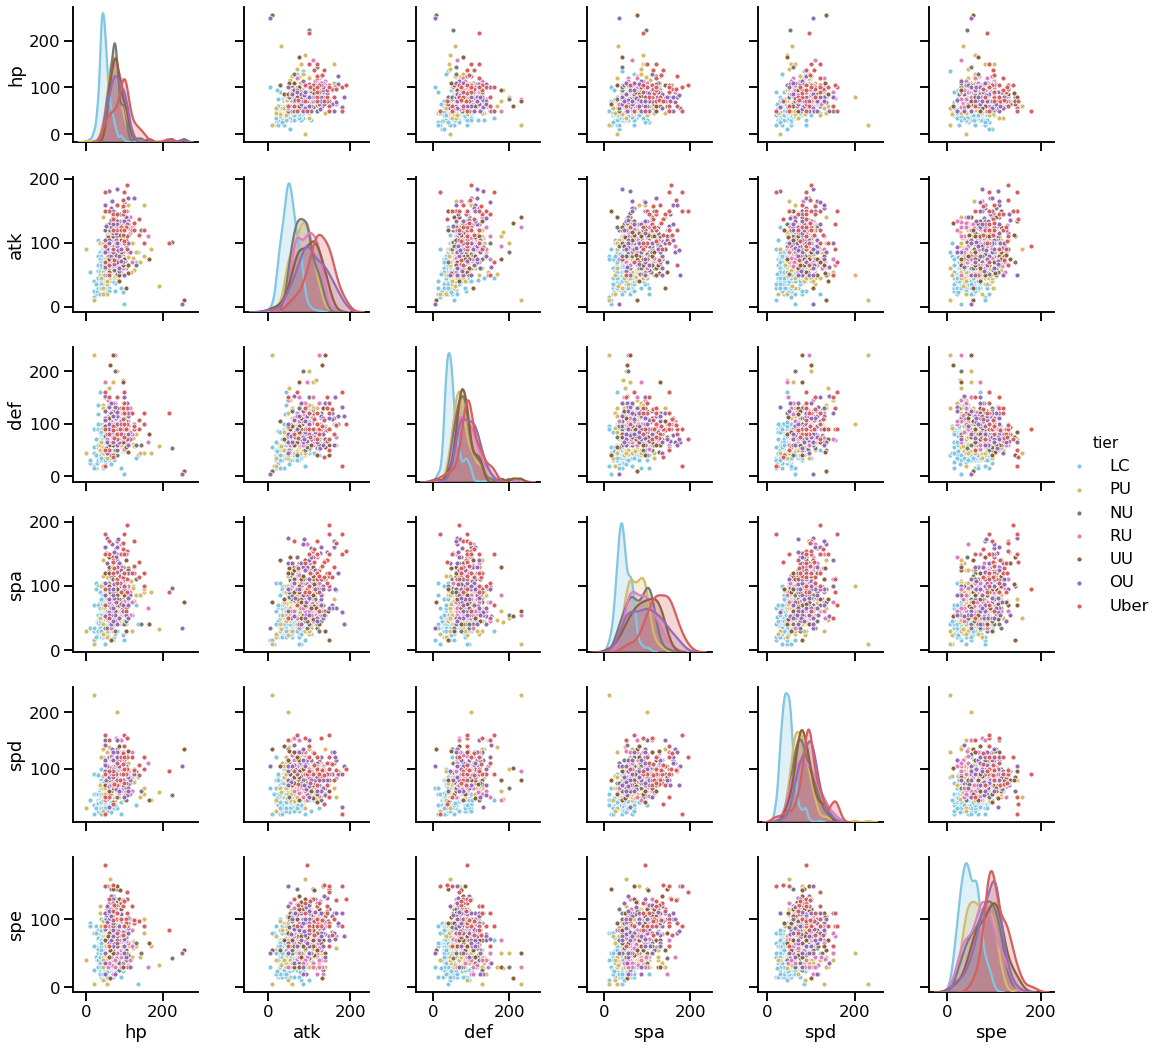

In [33]:
stats_df = df[['tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe']] #'tier_num', , 'bst'
sns.pairplot(stats_df, hue='tier', hue_order=list(reversed(tiers)), plot_kws={'s':25},
               palette=list(reversed(sns.color_palette('muted'))))

Variation per principal component: [0.45668265 0.19068992 0.13658632 0.09993901 0.073596   0.04250609]


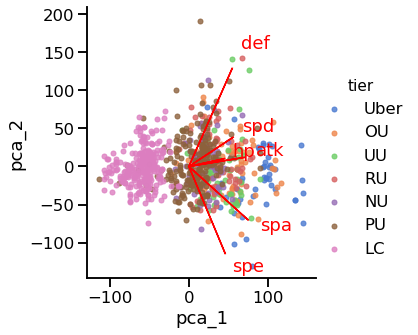

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
pca_result = pca.fit_transform(df[['hp', 'atk', 'def', 'spa', 'spd', 'spe']].values)
pca_df = df.copy()
pca_df = pca_df[['tier']]
pca_df['pca_1'] = pca_result[:,0]
pca_df['pca_2'] = pca_result[:,1] 
pca_df['pca_3'] = pca_result[:,2]
print(f'Variation per principal component: {pca.explained_variance_ratio_}')
sns.lmplot(data = pca_df, x='pca_1', y='pca_2', hue='tier', hue_order=tiers, fit_reg=False, palette='muted', scatter_kws={'s':25})

# below code from https://github.com/teddyroland/python-biplot/blob/master/biplot.py
xs = pca_df['pca_1']
ys = pca_df['pca_2']
xvector = pca.components_[0]
yvector = pca.components_[1]
dat = df[['hp', 'atk', 'def', 'spa', 'spd', 'spe']]

for i in range(len(xvector)):
    # arrows project features (ie columns from csv) as vectors onto PC axes
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(dat.columns.values)[i], color='r')

## Types

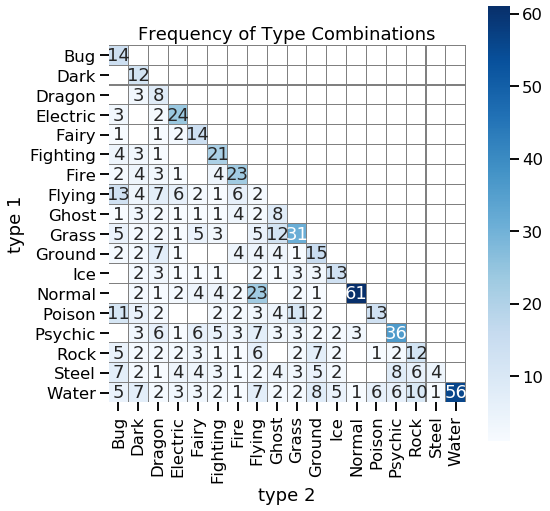

In [35]:
type_set = set()

for ind, row in df.iterrows():
    type_set |= set(row.types) #for use later

type_df_temp = df.copy()
type_df_temp['type 1'] = type_df_temp.apply(lambda x: sorted(x['types'])[0], axis=1)
type_df_temp['type 2'] = type_df_temp.apply(lambda x: sorted(x['types'])[-1], axis=1) #if a pokemon has a single type, type 2 = type 1

type_df = type_df_temp[['type 2', 'type 1']].groupby(['type 2', 'type 1']).size().reset_index()
type_df.columns = ['type 1', 'type 2', 'count']
type_pivoted_df = type_df.pivot('type 1', 'type 2', 'count')

plt.subplots(figsize=(8,8))
sns.heatmap(type_pivoted_df, annot=True, square=True, cmap='Blues', linecolor='grey', linewidths='0.05')
plt.gca().set(title='Frequency of Type Combinations');

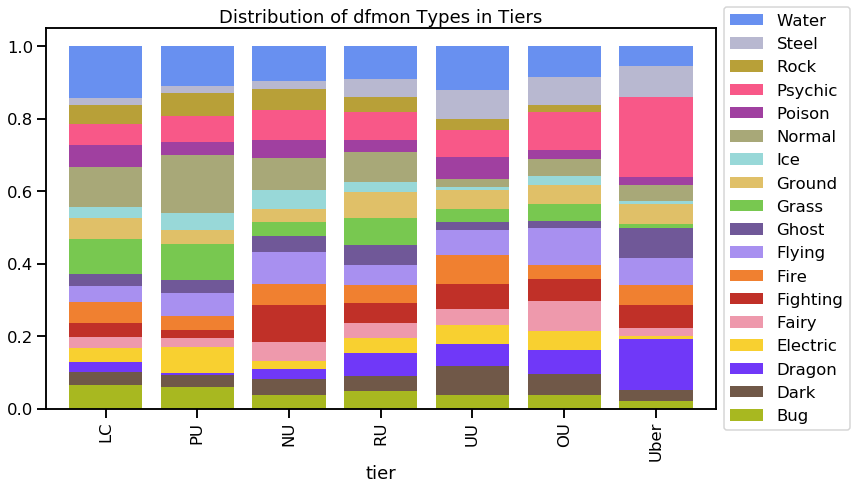

In [36]:
#Get individual counts of type1 and type 2
type1_count = type_df_temp[['tier', 'type 1']].groupby(['tier', 'type 1']).size().reset_index()
type2_count = type_df_temp[['tier', 'type 2']].groupby(['tier', 'type 2']).size().reset_index()
type1_count.columns=['tier', 'type', 'count1']
type2_count.columns=['tier', 'type', 'count2']

#Get overall type frequency per tier
type_count = pd.merge(type1_count, type2_count, on=['tier', 'type'], how='outer')
type_count.fillna(value=0, inplace=True)
type_count['count'] = type_count['count1'] + type_count['count2']
type_count_ind = type_count.set_index(['tier','type'])
type_count['count'] = type_count.apply(lambda x: x['count']/np.sum(type_count_ind.loc[x['tier'], 'count'])
                                      , axis=1) # /np.sum(type_count_ind2.loc[x['tier'], 'count'])

#Format Table and Sort rows
type_count = type_count[['tier','type','count']]
type_count = type_count.set_index(['tier','type']).unstack()['count']
type_count['tier_nums'] = type_count.apply(lambda x: tier_mapping[x.name],axis=1)
type_count = type_count.sort_values(by='tier_nums', ascending=False)
del type_count['tier_nums']

colors = [(104,144,240), (184,184,208), (184,160,56), (248,88,136), 
          (160,64,160), (168,168,120), (152,216,216), (224,192,104), 
          (120,200,80), (112,88,152), (168,144,240), (240,128,48), 
          (192,48,40), (238,153,172), (248,208,48), (112,56,248), 
          (112,88,72), (168,184,32)]
colors = [tuple(i/255.0 for i in c)
               for c in colors]
#Plit
type_count.plot.bar(stacked=True, title='Distribution of dfmon Types in Tiers', 
                     legend=False, figsize=(12, 7), sort_columns=True, width=0.8,
                    color=reversed(colors))
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), handles=handles[::-1])

Definitely more dragons, psychic and steel pokemon in higher tiers. Fewer normal, bug, and grass. Interestingly water which is considered the best type in the game isn't more prevalent likely because there are a lot of weak water types that are basically just fish

## Moves

In [37]:
mdf.set_index('name', inplace=True)

mdf['uber count'] = 0
mdf['ou count'] = 0
mdf['uu count'] = 0
mdf['ru count'] = 0
mdf['nu count'] = 0
mdf['pu count'] = 0
mdf['lc count'] = 0

for ind, row in df.iterrows():
    for move in row.moves:
        mdf.loc[move, row.tier.lower() + ' count'] += 1
        
mdf['count'] = mdf['uber count'] + mdf['ou count'] + mdf['uu count'] + mdf['ru count'] + mdf['nu count'] + mdf['pu count'] + mdf['lc count']
#mdf = mdf.reset_index()

### Signiture Moves

In [38]:
tier_size = { t:len(df[df.tier == t]) for t in tiers}
tier_size

{'Uber': 47, 'OU': 77, 'UU': 67, 'RU': 72, 'NU': 68, 'PU': 222, 'LC': 265}

[Text(0.5, 1.0, 'Distribution for All Move samong the Tiers')]

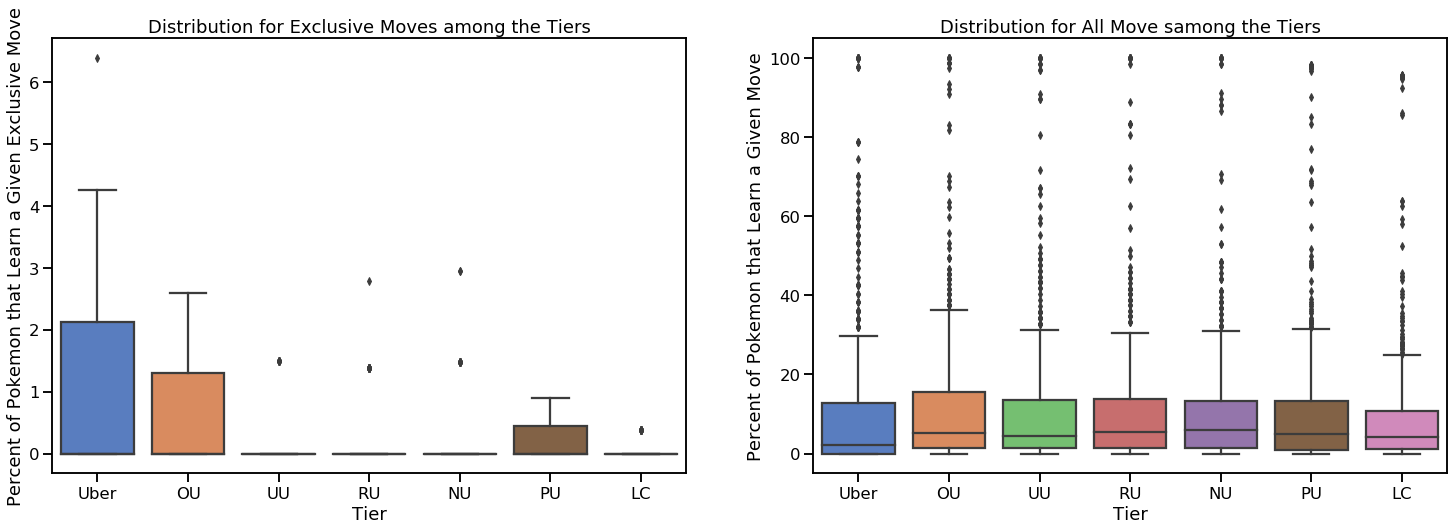

In [39]:
for t in tiers:
    mdf[t + ' %'] = mdf[t.lower() + ' count']/tier_size[t]*100

exclusives = mdf[mdf['count'] <= 3][[t + ' %' for t in tiers]].unstack().reset_index()
del exclusives['name']
exclusives.columns=['Tier', 'Percent of Pokemon that Learn a Given Exclusive Move']
exclusives['Tier'] = exclusives.apply(lambda x: x['Tier'].split(' ')[0], axis=1)

normals = mdf.copy()[[t + ' %' for t in tiers]].unstack().reset_index()
del normals['name']
normals.columns=['Tier', 'Percent of Pokemon that Learn a Given Move']
normals['Tier'] = normals.apply(lambda x: x['Tier'].split(' ')[0], axis=1)

fig, ax = plt.subplots(1,2, figsize=(25,8))
sns.boxplot(data=exclusives, x='Tier', y='Percent of Pokemon that Learn a Given Exclusive Move', palette='muted', ax=ax[0])
sns.boxplot(data=normals, x='Tier', y='Percent of Pokemon that Learn a Given Move', palette='muted', ax=ax[1])
ax[0].set(title='Distribution for Exclusive Moves among the Tiers')
ax[1].set(title='Distribution for All Move samong the Tiers')

In [40]:
exclusive_moves = set(mdf[mdf['count'] <= 3].index)
df['num_exclusive'] = df.apply(lambda x: len(exclusive_moves.intersection(x['moves'])), axis=1)

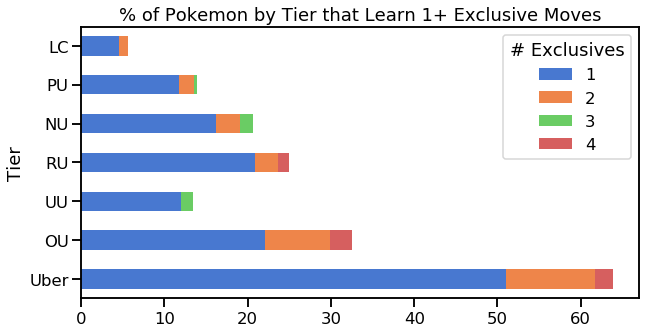

In [41]:
edf = df.loc[:, ['tier', 'tier_num', 'num_exclusive']]
edf['indicator'] = edf.apply(lambda x: 1 if x.num_exclusive > 0 else 0, axis=1)
edf = edf.pivot_table(values='indicator', index=['tier', 'tier_num'], columns='num_exclusive', fill_value=0, aggfunc=np.count_nonzero)
edf.reset_index(inplace=True)
edf.columns = ['Tier', 'tier_num'] + [str(i) for i in range(5)]
edf.sort_values('tier_num', inplace=True)
del edf['tier_num']
del edf['0']

for i in range(1,  5):
    edf[str(i)] = edf.apply(lambda x: x[str(i)]/tier_size[x['Tier']]*100, axis=1)

edf.set_index('Tier').plot.barh(stacked=True, color=sns.color_palette('muted'), figsize=(10, 5))
plt.gca().set(title='% of Pokemon by Tier that Learn 1+ Exclusive Moves')
plt.legend(title='# Exclusives')

### Strongest Moves

In [50]:
highest_moves = []
#we do not want to count moves with recharge as half power,
#as they waste a turn and are not used commonly used in competitive
moves_w_recharge = {'Blast Burn', 'Frenzy Plant', 'Giga Impact', 'Hydro Cannon',
                      'Hyper Beam', 'Prismatic Laster', 'Roar of Time', 'Rock Wrecker',
                      'Shadow Half'}
# a special move that lowers special atk is not that useful,
# similarly a physical move that lowers atk is not that useful
moves_lower_attack = {'Overheat', 'Draco Meteor', 'Leaf Storm', 'Fleur Cannon', 
                      'Psycho Boost', 'Superpower'}
#these moves cause the user to fiant, so they will not be included
self_destroy = {'Explosion', 'Self-Destruct'}

def get_max_power(moves, typ, category, min_acc):
    moves = list(set(moves) - moves_w_recharge)
    highest = np.max([mdf.loc[m, 'power'] if mdf.loc[m, 'category'] == category
                                          and mdf.loc[m, 'accuracy'] >= min_acc 
                                          and mdf.loc[m, 'type'] == typ
                                       else 0
                        for m in moves])
    return highest

def get_primary(x):
    atk_higher = x.atk >= x.spa
    spa_higher = x.spa >= x.atk
    candidates = []
    for t in x.types:
        candidates.append(x[t+'_physical'] if x.atk >= x.spa else 0)
        candidates.append(x[t+'_special'] if x.atk <= x.spa else 0)
    return np.max(candidates)

for t in tqdm_notebook(type_set):
    df[t+'_physical'] = df.apply(lambda x: get_max_power(x.moves, t, 'Physical', 85), axis=1)
    df[t+'_special'] = df.apply(lambda x: get_max_power(x.moves, t, 'Special', 85), axis=1)
    highest_moves += [t+'_physical', t+'_special']

df['primary_attack'] = df.apply(get_primary, axis=1)

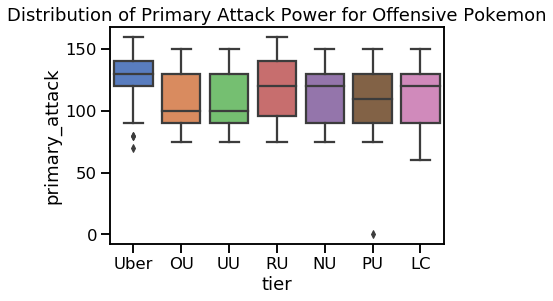

In [48]:
offensive_pokemon = df.apply(lambda x: max(x['atk'], x['spa']) > max(x['def'], x['spd']), axis=1)
a=sns.boxplot(data=df[offensive_pokemon], x='tier', y='primary_attack', palette='muted', order=tiers)
a.set(title='Distribution of Primary Attack Power for Offensive Pokemon');

In [49]:
move_set = set()

for ind, row in df.iterrows():
    move_set |= row.moves

move_df = df[['tier', 'tier_num']]

for m in move_set:
    move_df[m] = df.apply(lambda x: 1 if m in x.moves else 0, axis = 1)

## Abilities

In [51]:
from collections import defaultdict
a_dict = defaultdict(int)

for ind, row in df.iterrows():
    for ability in row.abilities:
        a_dict[(ability, row.tier + ' count')] += 1


adf = pd.DataFrame(pd.Series(a_dict)).reset_index() #(columns=(['name'] + [t + ' Count' for t in tiers]))
adf.columns=['name', 'tier', 'count']
adf = adf.pivot_table(values='count', index='name', columns='tier', fill_value=-0)
adf['count'] = sum(adf[t + ' count'] for t in tiers)

In [52]:
bad_abilities = {'Comatose', 'Defeatist', 'Emergency Exit', 'Slow Start', 'Truant', 'Wimp Out', 'Stall'}
df['bad_ability'] = df.apply(lambda x: 1 if len(set(x['abilities']).intersection(bad_abilities)) == len(x['abilities'])
                                       else 0, axis=1)
df[df.bad_ability == 1]

,types,abilities,tier,hp,atk,def,spa,spd,spe,next_evos,...,Ghost_physical,Ghost_special,Bug_physical,Bug_special,Fire_physical,Fire_special,Grass_physical,Grass_special,primary_attack,bad_ability
name,,,,,,,,,,,,,,,,,,,,,
Archen,"[Rock, Flying]",[Defeatist],LC,55,112,45,74,45,70,[Archeops],...,70.0,0.0,70.0,0.0,0.0,95.0,0.0,0.0,85.0,1
Archeops,"[Rock, Flying]",[Defeatist],NU,75,140,65,112,65,110,[],...,70.0,0.0,70.0,0.0,0.0,95.0,0.0,0.0,140.0,1
Golisopod,"[Bug, Water]",[Emergency Exit],RU,75,125,140,60,90,40,[],...,70.0,0.0,90.0,50.0,0.0,0.0,0.0,0.0,90.0,1
Komala,[Normal],[Comatose],PU,65,115,65,75,95,65,[],...,70.0,0.0,70.0,0.0,0.0,0.0,120.0,0.0,120.0,1
Regigigas,[Normal],[Slow Start],PU,110,160,110,80,110,100,[],...,0.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0,90.0,1
Slaking,[Normal],[Truant],PU,150,160,100,95,65,100,[],...,70.0,80.0,40.0,0.0,75.0,110.0,0.0,120.0,120.0,1
Slakoth,[Normal],[Truant],LC,60,60,60,35,35,30,[Vigoroth],...,70.0,80.0,40.0,0.0,75.0,110.0,0.0,120.0,120.0,1
Wimpod,"[Bug, Water]",[Wimp Out],LC,25,35,40,20,30,80,[Golisopod],...,0.0,0.0,80.0,50.0,0.0,0.0,0.0,0.0,80.0,1


## Evolution

<Figure size 1440x288 with 0 Axes>

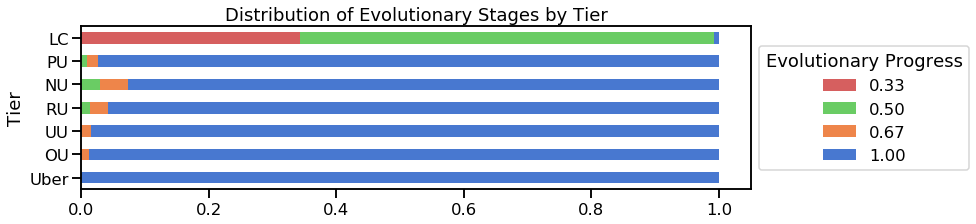

In [55]:
evodf = df.loc[:, ['tier', 'tier_num', 'evo_progress']]
evodf['count'] = evodf.apply(lambda x: 1/tier_size[x.tier], axis=1) 
#so when we sum everything up, values will be normalized to tier size
evodf = evodf.pivot_table(values='count', index=['tier', 'tier_num'], columns='evo_progress', fill_value=0, aggfunc=np.sum)
evodf = evodf.sort_values('tier_num').reset_index()
del evodf['tier_num']
evodf.columns = ['Tier', '0.33','0.50', '0.67', '1.00']
evodf.set_index('Tier', inplace=True)

plt.figure(figsize=(20, 4))
evodf.plot.barh(stacked=True, color=sns.color_palette('muted')[3::-1], figsize=(12, 3), 
                title='Distribution of Evolutionary Stages by Tier')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),title='Evolutionary Progress')

Little cup pokemon are very easily distinguished by their evolutionary stage. but after that it becomes a little more complicated. Regardless this feature is likely very useful

### Forms

<Figure size 1440x288 with 0 Axes>

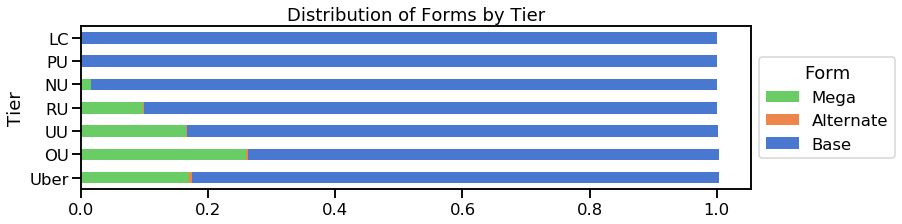

In [57]:
altdf = df.loc[:, ['tier', 'tier_num', 'mega', 'alt_form']]
altdf['mega'] = altdf.apply(lambda x: x.mega/tier_size[x.tier], axis=1) 
altdf['alt_form'] = altdf.apply(lambda x: x.mega/tier_size[x.tier], axis=1)
altdf['normal'] = altdf.apply(lambda x: 1/tier_size[x.tier] if x['mega'] == 0 and x['alt_form'] == 0 else 0, axis=1)
#so when we sum everything up, values will be normalized to tier size

#altdf = altdf.pivot_table(values='count', index=['tier', 'tier_num'], columns='evo progress', fill_value=0, aggfunc=np.sum)
altdf = altdf.groupby(['tier', 'tier_num']).agg(np.sum).reset_index().sort_values('tier_num')
del altdf['tier_num']
altdf.columns = ['Tier', 'Mega', 'Alternate', 'Base']
altdf.set_index('Tier', inplace=True)

plt.figure(figsize=(20, 4))
altdf.plot.barh(stacked=True, color=sns.color_palette('muted')[2::-1], figsize=(12, 3), 
                title='Distribution of Forms by Tier')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),title='Form')

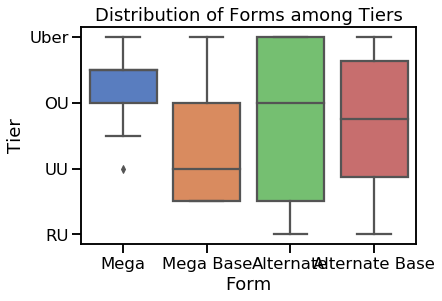

In [58]:
alt = df.loc[(df['alt_form'] == 1), ['tier_num']]
mega = df.loc[(df['mega'] == 1), ['tier_num']]
alt_base = df.loc[set(map(lambda x: x.split('-')[0], alt.index)), ['tier_num']]
mega_base = df.loc[set(map(lambda x: x.split('-')[0], mega.index)), ['tier_num']]

alt['Form'] = 'Alternate'
mega['Form'] = 'Mega'
alt_base['Form'] = 'Alternate Base'
mega_base['Form'] = 'Mega Base'

combined = pd.concat([mega, mega_base, alt, alt_base])
combined.columns = ['Tier', 'Form']
plt.gca().invert_yaxis()
plt.gca().set(title='Distribution of Forms among Tiers', yticklabels=['']+tiers)
sns.boxplot(data=combined, x='Form', y='Tier', palette='muted')

## Setup

In [59]:
stat_increasing = {'Coil': 3, 'Hone Claws': 2, 'Belly Drum': 6, 'Bulk Up': 2, 'Clangorous Soulblaze': 4, 
                   'Dragon Dance': 2, 'Shell Smash': 4, 'Shift Gear': 3, 'Swords Dance': 2, 'Work Up': 2,
                   'Cosmic Power': 2,  'Defend Order': 2, 'Calm Mind': 2, 'Geomancy': 6, 
                   'Nasty Plot': 2, 'Quiver Dance': 3, 'Tail Glow': 3, 'Agility': 2, 'Automize': 2, 'Rock Polish': 2}


df['stat_inc_move'] = df.apply(lambda x: np.max([0]+[stat_increasing[v] for v in x.moves.intersection(stat_increasing)]), axis=1)

In [60]:
atk_inc_ability = {'Huge Power', 'Pure Power'}
df['atk_inc_ability'] = df.apply(lambda x: 1 if len(set(x.abilities).intersection({'Huge Power', 'Pure Power'})) > 0 else 0, axis=1)

In [61]:
recovery = {'Heal Order', 'Milk Drink', 'Moonlight', 'Morning Sun', 'Purify', 'Recover',
            'Roost', 'Shore Up', 'Slack Off', 'Soft-Boiled', 'Synthesis', 'Strength Sap', 'Wish'}
df['recovery_move'] = df.apply(lambda x: 1 if len(x.moves.intersection(recovery)) > 0 else 0, axis=1)

In [62]:
priority = {'Fake Out', 'Extreme Speed', 'Feint', 'Aqua Jet', 'Bullet Punch', 'Ice Shard', 'Accelerock'
            'Mach Punch', 'Shadow Sneak', 'Sucker Punch', 'Vacuum Wave', 'Water Shuriken'}
df['priority_stab'] = df.apply(lambda x: 1 if any([(mdf.loc[m, 'type'] in x.types) 
                                                   for m in x.moves.intersection(priority)]) else 0,
                               axis=1)

No megas in lower tiers, mostly in UU, OU, and Ubers

# Modeling

## Preprocessing

In [63]:
#To do this efficiently, we will simply create a dictionary of moves and abilities.
#We will map all of them to themselves to start, then alter the variations
ability_set = set()
move_set = set()
type_set = set()

for ind, row in df.iterrows():
    ability_set |=  set(row.abilities) #union
    move_set |= row.moves
    type_set |= set(row.types)

ability_dict = {s:{s} for s in ability_set if s not in {
                   'Battle Armor', 'White Smoke', 'Full Metal Body', 'Solid Rock', 'Prism Armor', 'Gooey', 
                   'Magnet Pull', 'Shadow Tag', 'Inner Focus', 'Insomnia', 'Vital Spirit', 'Limber', 'Magma Armor', 
                  'Own Tempo', 'Oblivious', 'Water Veil', 'Sweet Veil', 'Aroma Veil', 'Hyper Cutter', 'Big Pecks',
                   'Triage', 'Heatproof', 'Iron Barbs', 'Quick Feet', 'Flare Boost', 'Toxic Boost'
               }} #dictionary of sets

#We will not consolidate weather-variations because the viability of various weather conditions varies

ability_dict['Shell Armor'].add('Battle Armor')
ability_dict['Clear Body'] |= {'White Smoke', 'Full Metal Body'}
ability_dict['Filter'] |= {'Solid Rock', 'Prism Armor'}
ability_dict['Tangling Hair'].add('Gooey')

# Below are cases where the abilities aren't identical, but close enough
ability_dict['Arena Trap'] |= {'Magnet Pull', 'Shadow Tag'} 
ability_dict['Guts'] |= {'Quick Feet', 'Flare Boost', 'Toxic Boost'} # Marvel scale is excluded from this because it boosts defense
ability_dict['Immunity'] |= {'Inner Focus', 'Insomnia', 'Vital Spirit', 'Limber', 'Magma Armor', 
          'Own Tempo', 'Oblivious', 'Water Veil', 'Sweet Veil', 'Aroma Veil'}
ability_dict['Keen Eye'] |= {'Hyper Cutter', 'Big Pecks'} 
ability_dict['Prankster'].add('Triage')
ability_dict['Thick Fat'].add('Heatproof')
ability_dict['Rough Skin'].add('Iron Barbs')
#water absorb and dry skin?

In [64]:
entry_hazards = {'Toxic Spikes', 'Stealth Rock', 'Spikes'}
df['entry_hazards'] = df.apply(lambda x: 1 if len(x.moves.intersection(entry_hazards)) > 0 else 0, axis=1)

hazard_clear = {'Rapid Spin'} #we may later exclude/add defog 
df['hazard_clear'] = df.apply(lambda x: 1 if len(x.moves.intersection(hazard_clear)) > 0 else 0, axis=1)

phazing_moves = {'Roar', 'Whirlwind', 'Dragon Tail', 'Circle Throw'}
df['phazing_moves'] = df.apply(lambda x: 1 if len(x.moves.intersection(phazing_moves)) > 0 else 0, axis=1)

switch_attack = {'U-turn', 'Volt Switch'}
df['switch_attack'] = df.apply(lambda x: 1 if len(x.moves.intersection(switch_attack)) > 0 else 0, axis=1)

#strong moves (>65 power) that have a >30% chance of causing side effects with an accuracy over 85%
high_side_fx_prob = {'Steam Eruption','Sludge Bomb', 'Lava Plume', 'Iron Tail', 'Searing Shot', 
                     'Rolling Kick', 'Rock Slide', 'Poison Jab', 'Muddy Water', 'Iron Head',
                    'Icicle Crash', 'Headbutt', 'Gunk Shot', 'Discharge', 'Body Slam', 'Air Slash'}
df['high_side_fx_prob'] = df.apply(lambda x: 1 if len(x.moves.intersection(high_side_fx_prob)) > 0 else 0, axis=1)

constant_dmg = {'Seismic Toss', 'Night Shade'}
df['constant_dmg'] = df.apply(lambda x: 1 if len(x.moves.intersection(constant_dmg)) > 0 else 0, axis=1)

trapping_move = {'Mean Look', 'Block', 'Spider Web'}
df['trapping_move'] = df.apply(lambda x: 1 if len(x.moves.intersection(trapping_move)) > 0 else 0, axis=1)

In [65]:
stats = ['hp', 'atk', 'def', 'spa', 'spd', 'spe'] #bst excluded
forms = ['evo_progress', 'mega', 'alt_form']
moves_based = ['num_moves','num_exclusive', 'bad_ability', 'stat_inc_move', 'recovery_move', 'priority_stab',
              'entry_hazards', 'hazard_clear', 'phazing_moves', 'switch_attack', 'high_side_fx_prob', 'constant_dmg',
              'trapping_move']
ability_based = ['atk_inc_ability', 'bad_ability']

df_y = df.loc[:, 'tier_num']
df_x = df.loc[:, stats + forms + moves_based + ability_based + highest_moves] 
#remove bst because it is just a sum of the individual stats

In [66]:
ability_set -= atk_inc_ability | bad_abilities | set(adf[adf['count'] <= 2].index)
move_set -=  stat_increasing.keys() | recovery | priority | set(mdf[(mdf['count'] <= 3) | (mdf['power'] > 0)].index) \
             | entry_hazards | hazard_clear | phazing_moves | switch_attack | high_side_fx_prob | constant_dmg | trapping_move

for a in ability_dict.keys():
    df_x[a] = df.apply(lambda x: 1 if len(ability_dict[a].intersection(x.abilities))>0 else 0, axis = 1)
for m in move_set:
    df_x[m] = df.apply(lambda x: 1 if m in x.moves else 0, axis = 1)
for t in type_set:
    df_x[t] = df.apply(lambda x: 1 if t in x.types else 0, axis = 1)

## Lasso Model

In [98]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [74]:
X = df_x
y = df_y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [100]:
pipe = Pipeline([
    ('lr', Lasso())
])

In [101]:
pipe_params = {
    'lr__alpha': [0, .5, 1, 1.5, 2]
}

In [102]:
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train)
print('CV Score:', gs.best_score_)
print('train', rmse(gs.predict(X_train), y_train))
print('test', rmse(gs.predict(X_test), y_test))
print('Param:', gs.best_params_)

CV Score: 0.6816144751558437
train 1.0412440523179065
test 1.1291032081497612
Param: {'lr__alpha': 1}


## Random Forest

In [104]:
pipe = Pipeline([
    ('rf', RandomForestRegressor())
])
pipe_params = {
    'rf__n_estimators': [15, 20],
    'rf__max_depth': [40, 50, 60],
    'rf__max_features': ['auto'],
}

In [105]:
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train)
print('CV Score:', gs.best_score_)
print('train', rmse(gs.predict(X_train), y_train))
print('test', rmse(gs.predict(X_test), y_test))
print('Param:', gs.best_params_)

CV Score: 0.746484777922034
train 0.40535264489212863
test 1.058450316817342
Param: {'rf__max_depth': 40, 'rf__max_features': 'auto', 'rf__n_estimators': 20}


## Gradient Boost

In [106]:
pipe = Pipeline([
    ('gb', GradientBoostingRegressor())
])
pipe_params = {
    'gb__learning_rate': [0.1, 0.2, 0.3],
}

In [135]:
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train)
pred_train = gs.predict(X_train)
pred_test = gs.predict(X_test)
y_hat = np.ceil(pred_test)
y_hat = np.where(y_hat==7, 6, y_hat)
y_hat = np.where(y_hat==-0, 0, y_hat) 
print('CV Score:', gs.best_score_)
print('RMSE Train:', rmse(pred_train, y_train))
print('RMSE Test:', rmse(pred_test, y_test))
print('Test Accuracy:', accuracy_score(y_hat, y_test))
print('Param:', gs.best_params_)

CV Score: 0.7636749406337578
RMSE Train: 0.5161440323839529
RMSE Test: 0.9852885771374202
Test Accuracy: 0.5804878048780487
Param: {'gb__learning_rate': 0.1}


## Neural Network